#**Tutorial 4: Understanding Climatology - Precipitation**

> Indented block

> Indented block




**Week 1, Day 4, Remote Sensing**

**Content creators:** Douglas Rao

**Content reviewers:** TBD

**Content editors:** TBD

**Production editors:** TBD

**Our 2023 Sponsors:** TBD

#**Tutorial Objectives**

In this tutorial, you will learn what is climatology and how to calculate climatology from satellite climate data.

By the end of this tutorial you will be able to:

* Understand the concept of climatology
* Calculate the climatology using long term satellite climate data
* Create meaningful maps including projection, coastlines, and other advanced features 


#**Setup**



In this section, we have:


1.   **Import cell:** imports all libraries you use in the tutorial.
2.   **Hidden Figure settings cell:** sets up the plotting style (copy exactly)
1.   **Hidden Plotting functions cell:** contains all functions used to create plots throughout the tutorial (so students don't waste time looking at boilerplate matplotlib but can here if they wish to). Please use only matplotlib for plotting for consistency.
2.   **Hidden Helper functions cell:** This should contain functions that students have previously used or that are very simple. Any helper functions that are being used for the first time and are important should be placed directly above the relevant text or exercise (see Section 1.1 for an example).
    



In [ ]:
#Imports

# Import only the libraries/objects that you use in this tutorial. 

# If any external library has to be installed, !pip install library --quiet
# follow this order: numpy>matplotlib. 
# import widgets in hidden Figure settings cell

# !pip install s3fs --quiet

# Properly install cartopy in colab to avoid session crash
# !apt-get install libproj-dev proj-data proj-bin --quiet
# !apt-get install libgeos-dev --quiet
# !pip install cython --quiet
# !pip install cartopy --quiet

# !apt-get -qq install python-cartopy python3-cartopy  --quiet
# !pip uninstall -y shapely  --quiet
# !pip install shapely --no-binary shapely  --quiet

In [1]:
import s3fs
import xarray as xr
import matplotlib.pyplot as plt
import cartopy, cartopy.crs as ccrs

zsh:1: command not found: apt-get
zsh:1: command not found: apt-get
zsh:1: command not found: apt-get


In [2]:
# @title Figure settings
import ipywidgets as widgets       # interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/ClimateMatchAcademy/course-content/main/cma.mplstyle")


#**Section 1: Access Monthly Precipitation Data**



In [3]:
# @title Video 1: Video 1 Name 
#Tech team will add code to format and display the video

In this tutorial, we will use the monthly precipitation climate data records data from NOAA to demonstrate how to calculate the long term climatology for climate analysis.

The data we are using is the [Global Precipitation Climatology Project (GPCP) Monthly Precipitation Climate Data Record (CDR)](https://www.ncei.noaa.gov/products/climate-data-records/precipitation-gpcp-monthly). It provides monthly satellite-gauge and associated precipitation error estimates taken from January 1979–present on a 2.5°×2.5° grid. The CDR is created by combining the precipitation information from several satellite and in situ sources into a final merged product that uses the strengths of each data type to create a more accurate record.  

There is also a higher spatial resolution (1°×1°) at daily resolution for different applications. Due to computational concerns, we are only using the coarser resolution monthly data. You are encouraged to explore the use of the daily higher resolution data for your project.

##**Section 1.1: Access GPCP Monthly CDR data on AWS**

To perform analysis, we will need to access the monthly data files from AWS first. We will use the skills that we learned from last tutorial on accessing data from an AWS S3 bucket.

In [4]:
# Connect to the AWS S3 bucket for the GPCP Monthly Precipitation CDR data
fs = s3fs.S3FileSystem(anon=True)

# Get the list of all data files in the AWS S3 bucket fit the data file pattern.
file_pattern = 'noaa-cdr-precip-gpcp-monthly-pds/data/*/gpcp_v02r03_monthly_*.nc'
file_location = fs.glob(file_pattern)

In [5]:
print("Total number of GPCP Monthly precipitation data files:")
print(len(file_location))

Total number of GPCP Monthly precipitation data files:
529


We have 528 GPCP monthly precipitation CDR data files in the AWS S3 buckect. Each data file contains the data of each month globally starting from January 1979. Now, let's open single data file to look at the data strcuture before we open all data files.

In [6]:
# First, open connection to all data files
file_ob = [fs.open(file) for file in file_location]

# Read single data file to understand the file structure
ds_single = xr.open_dataset(file_ob[0])

In [7]:
# Check how many variables are inluded in one data file
ds_single.data_vars

Data variables:
    lat_bounds    (latitude, nv) float32 ...
    lon_bounds    (longitude, nv) float32 ...
    time_bounds   (time, nv) datetime64[ns] ...
    precip        (time, latitude, longitude) float32 ...
    precip_error  (time, latitude, longitude) float32 ...

From the information provided by `xarray`, there are totally five data variables in this monthly data file, including `precip` for the monthly precipitation and `precip_error` for the monthly precipitation error.


In [8]:
# Check the coordinates for the data file
ds_single.coords

Coordinates:
  * latitude   (latitude) float32 -88.75 -86.25 -83.75 ... 83.75 86.25 88.75
  * longitude  (longitude) float32 1.25 3.75 6.25 8.75 ... 353.8 356.2 358.8
  * time       (time) datetime64[ns] 1979-01-01

All data is organised in three dimensions: `latitude`, `longitude`, and `time`. If we want to create a three-dimensional data array for the monthly precipitation data across the entire data period (from January 1979 until present).

In [9]:
# Open all the monthly data files and concatenate them along the time dimension.
# This process will take ~ 1 minute to complete due to the number of data files.   
ds = xr.open_mfdataset(file_ob, combine='nested', concat_dim='time') 

Since we are mostly interested in the precipitation data globally at this moment, let's extract the data array of precipitation from the entire dataset.

In [10]:
# Examine the precipitation data variable
precip = ds.precip
precip

<xarray.DataArray 'precip' (time: 529, latitude: 72, longitude: 144)>
dask.array<concatenate, shape=(529, 72, 144), dtype=float32, chunksize=(1, 72, 144), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 -88.75 -86.25 -83.75 ... 83.75 86.25 88.75
  * longitude  (longitude) float32 1.25 3.75 6.25 8.75 ... 353.8 356.2 358.8
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2023-01-01
Attributes:
    long_name:      NOAA Climate Data Record (CDR) of GPCP Monthly Satellite-...
    standard_name:  precipitation amount
    units:          mm/day
    valid_range:    [  0. 100.]
    cell_methods:   area: mean time: mean

As you can see, the data array has the dimension of `time=528` `longitude=144` `latitude=72`. Let's visualize the precipitation data to better understand it before further analysis.

##**Section 1.2: Visualize GPCP Data with Additional Map Features**

In previous tutorials, we learned how to make simple visualization using `matplotlib` using `latitude` and `longitude` as the y-axis and x-axis.

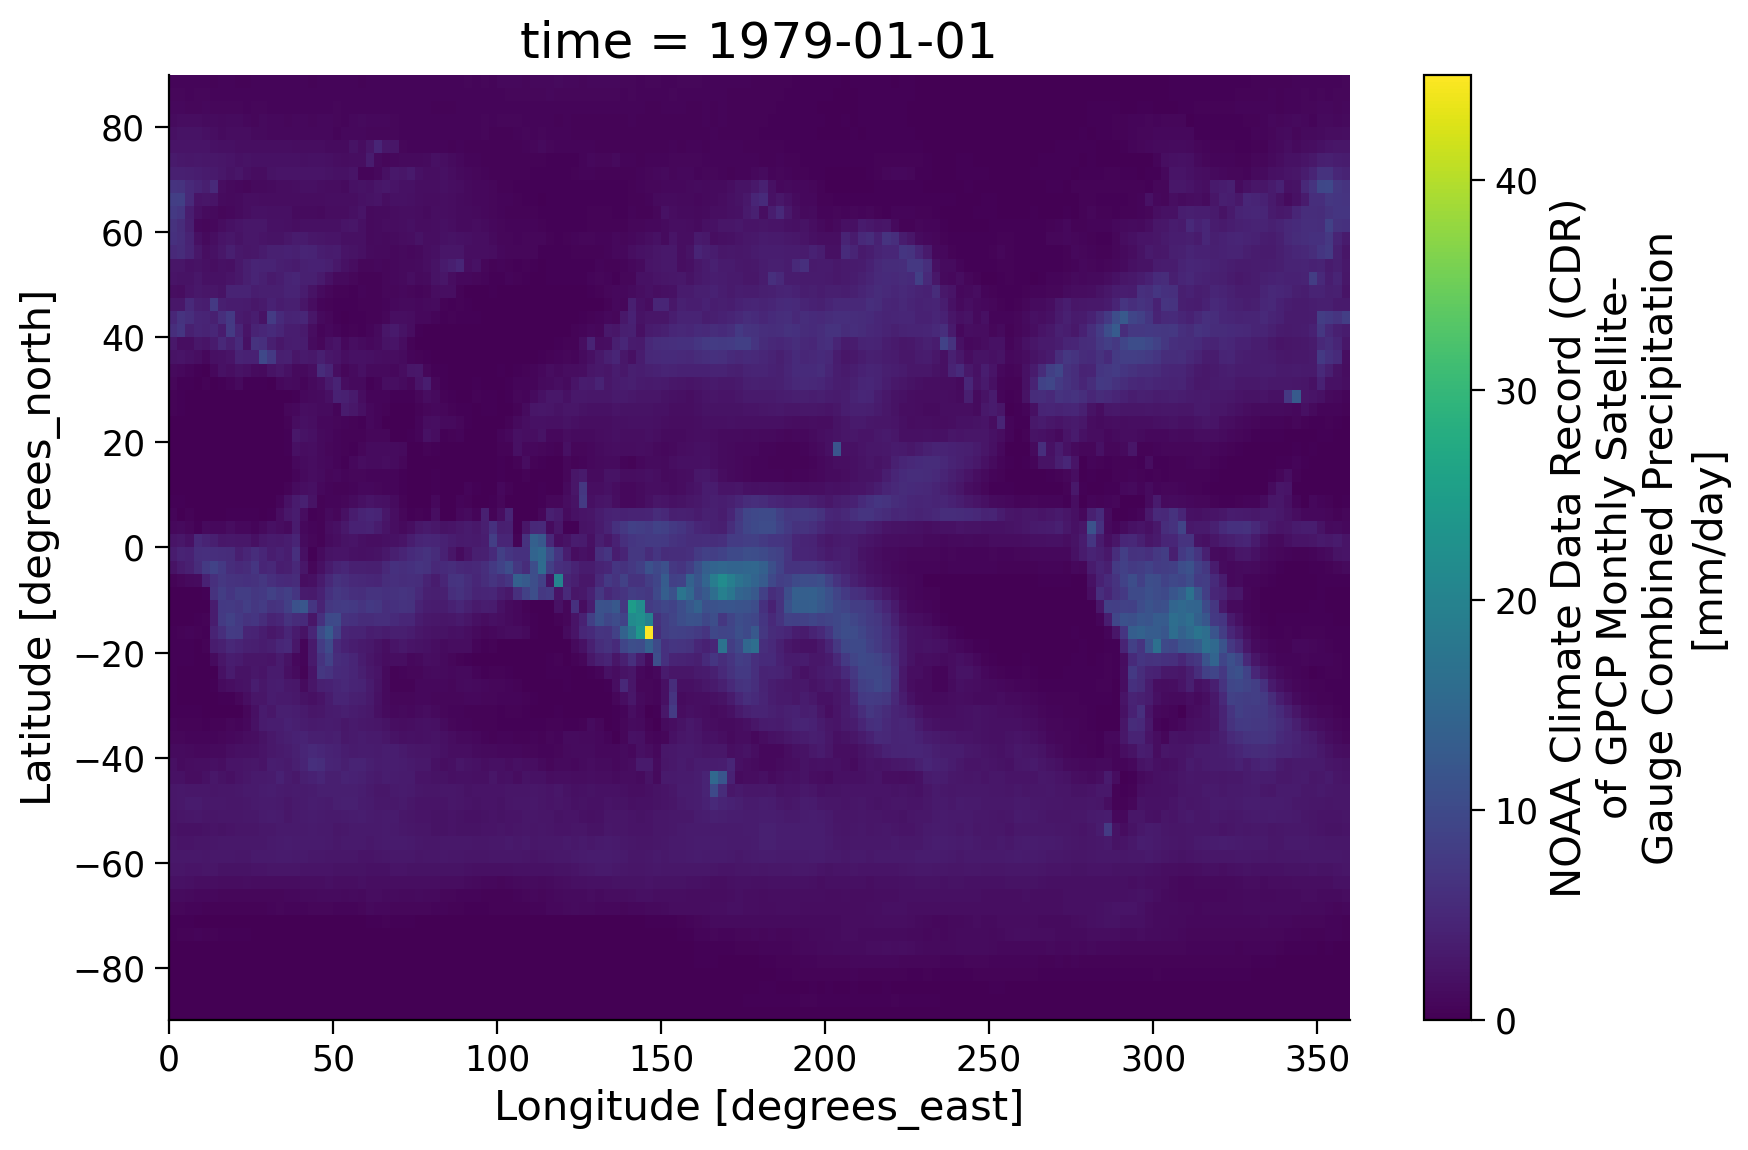

In [11]:
# Create simple map of the GPCP precipitation data using matplotlib
fig = plt.figure(figsize=(9,6))
# Use the first month of data as an example
precip.sel(time='1979-01-01').plot()

From the figure, you can vaguely see the boundary of land and ocean. Particularly for the North and South America. But this is not an ideal situation for visualize the data since we don't want to put any guess work in where we are looking at. So, we will now use `cartopy` to create the visualization with more advanced map features, such as, adding coastal lines, major grid marking, and creating maps with a specific projection for better science communication and climate applications.

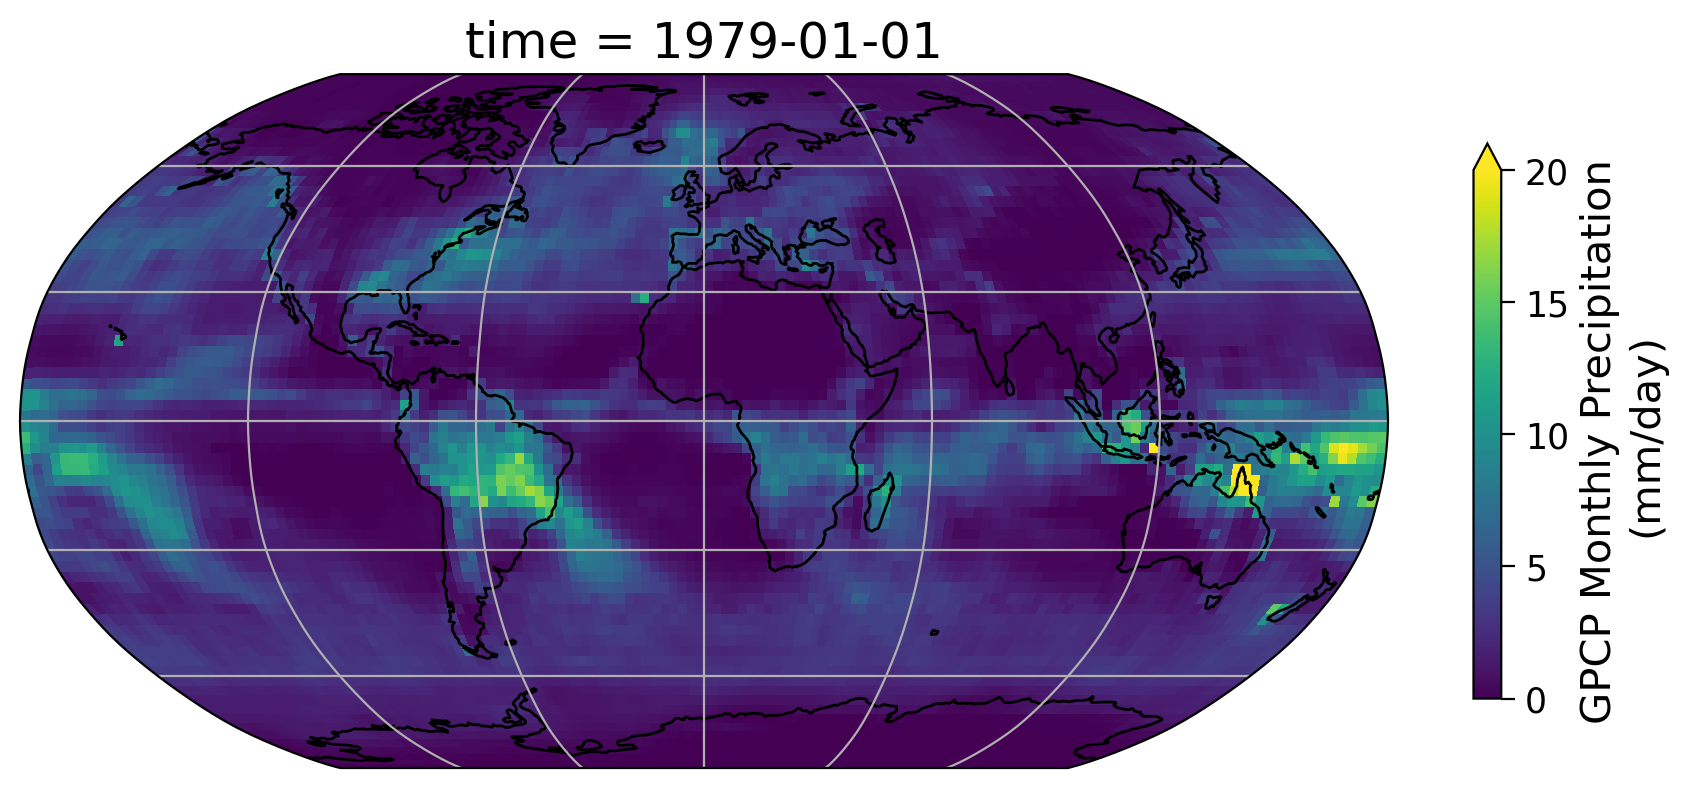

In [12]:
# Visualize the precipitation data of a selected month using cartopy
# Select data for the month of interest
data = precip.sel(time='1979-01-01', method='nearest')
# Initate plot with the specific figure size
fig = plt.figure(figsize=(9,6))
# Set base map projection
ax = plt.axes(projection=ccrs.Robinson())
# Add coastal lines to indicate land/ocean
ax.coastlines()
# Add major grid lines for latitude and longitute
ax.gridlines()
# Add the precipitation data with map projection transformation
# Also specify the maximum and minumum value show on the map to increase the 
# contrast in the map.
data.plot(ax=ax, transform=ccrs.PlateCarree(),
          vmin=0, vmax=20, cbar_kwargs=dict(shrink=0.5, label='GPCP Monthly Precipitation \n(mm/day)'))

The new map is much improved and gives us more information to better understand the GPCP monthly precipitation data. As we can see, Amazon rainforest, northern part of Australia, other tropical regions show higher amount of monthly precipitation during the month of January in 1979, which fits our basic knowledge of geography.

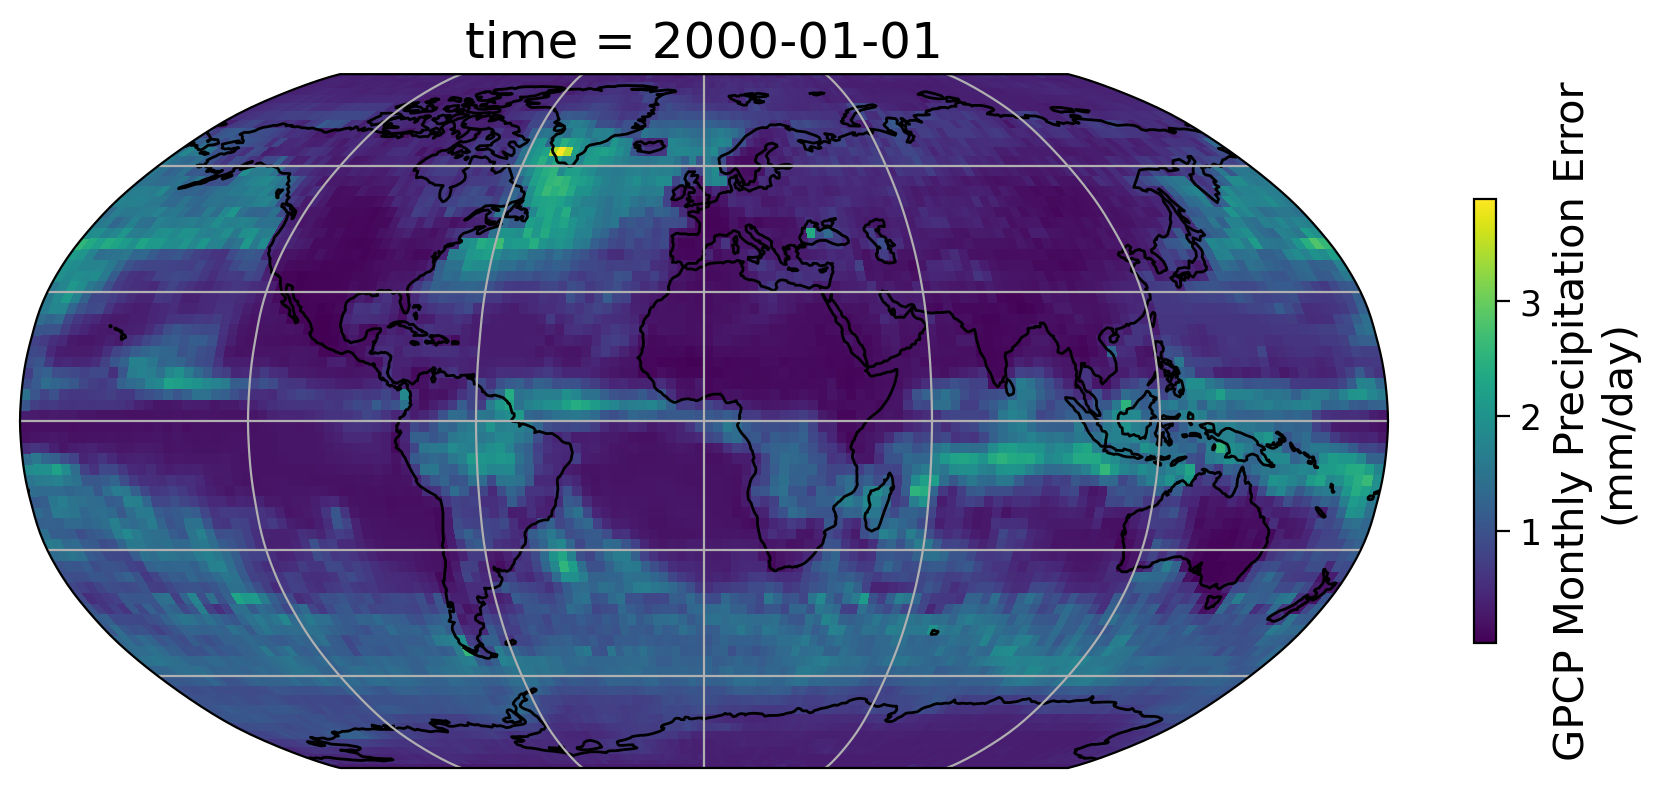

In [13]:
# Select data for the month of interest
data = ds.precip_error.sel(time='2000-01-01', method='nearest')

# Initate plot
fig = plt.figure(figsize=(9,6))
# Set map projection
ax = plt.axes(projection=ccrs.Robinson())
# Add coastal lines to indicate land/ocean
ax.coastlines()
# Add grid lines for latitude and longitute
ax.gridlines()
# Add the precipitation data for 
data.plot(ax=ax, transform=ccrs.PlateCarree(),
          cbar_kwargs=dict(shrink=0.4, label='GPCP Monthly Precipitation Error\n(mm/day)'))

### **Exercise 1.2: How big is the error?**

Remember GPCP also offers a data variable that document the error of the estimated monthly precipitation data. The error information can be very helpful information for us to understand how confident should we be about for this data.

In this exercise, can you generate the precipitation error for the same month (1979-01-01) use the examples above?

In [14]:
################################################################################
# Exercise: create precipitation error map for the month of January 1979       #
#           using GPCP monthly data.                                           #
################################################################################

# Step 1: Select data for the month of interest using '.sel'
error = ...
# Step 2: Initate plot
fig = ...
# Step 3: Set map projection
ax = ...
# Step 4: Add coastal lines to indicate land/ocean
...
# Step 5: Add grid lines for latitude and longitute
...
# Step 6: Plot the precipitation error with a reasonable data range 
...


Ellipsis

Can you comment on the spatial pattern of the precipitation error provided by GPCP CDR data for this specific month?

In [15]:
# Please write about the error information based on the map above.
'''
Write you comments here
'''

'\nWrite you comments here\n'

## **Section 2: Climatology**

We have more than 40 years of monthly precipitation data. Let's take a look at a specific location about the entire time duration that we have the GPCP monthly data. Randomly, we are looking at the data point at (0°N, 0°E).

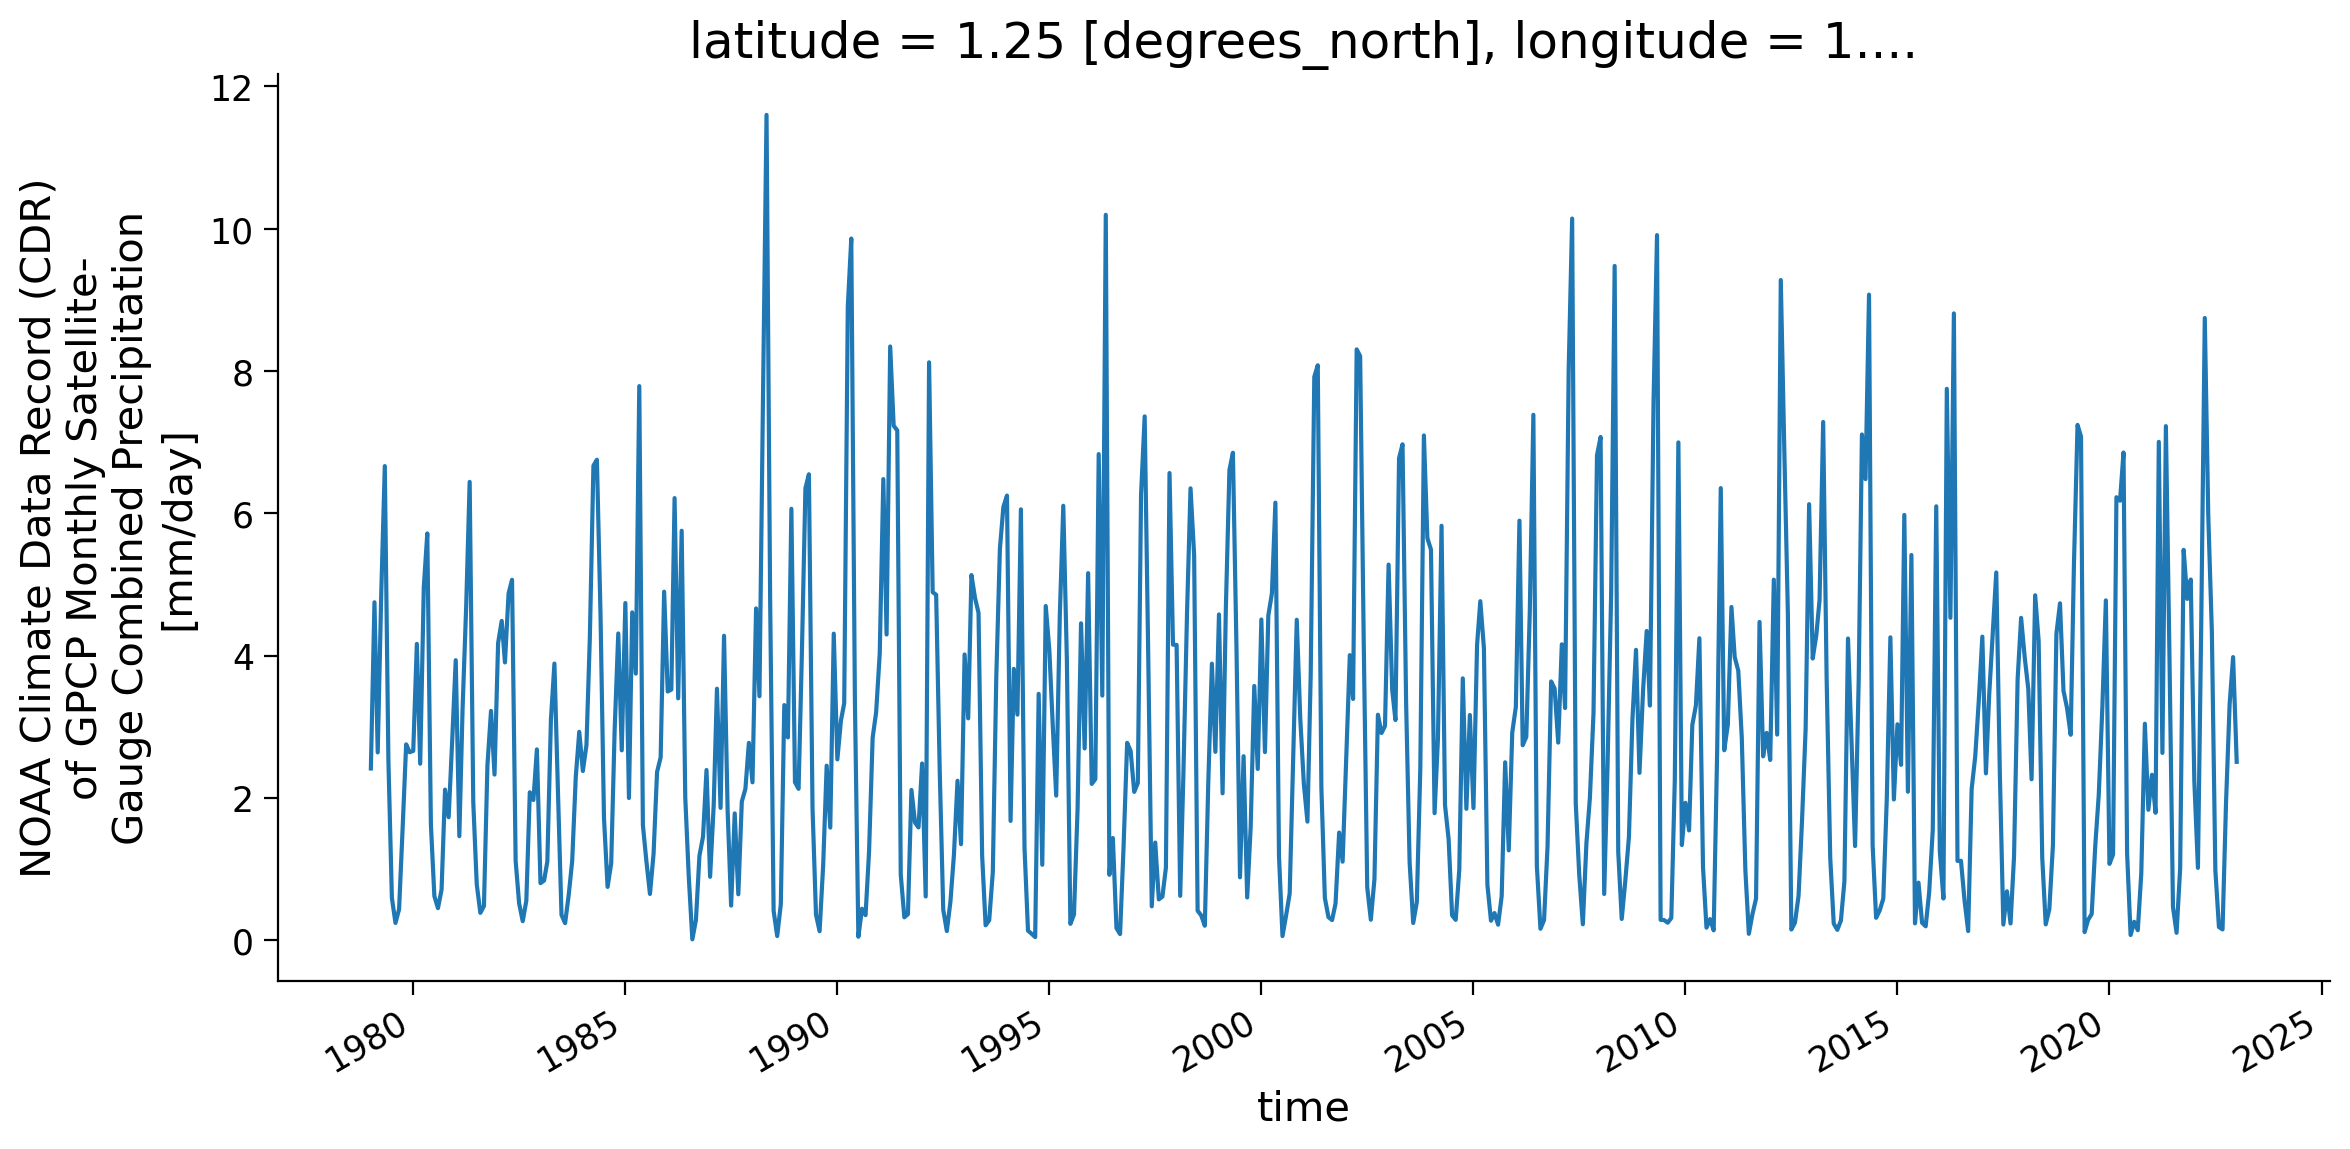

In [16]:
# select the entire time series for the grid that contains the location of (0N, 0E)
grid = ds.precip.sel(latitude=0, longitude=0, method='nearest')
# Initate plot
fig = plt.figure(figsize=(12,6))
grid.plot()

From the time series plot, it looks like we have a repeating pattern with seasonal cycle. When we talk about climatology, we often mean the pattern that is averaged over a long time period (e.g., typically 30 years). Climatology can tell us what the weather will typically be like in certain time of the year.

For example, for a given location, we know summer will be the hottest season of the year. This can also apply to rainy/dry seasons. Now let's calculate the monthly climatology of precipitation using GPCP monthly data.

In [17]:
# First, let's extract the data for the time period that we want to use to 
# calulate climatology (1981-2010)
precip_30yr = ds.precip.sel(time=slice('1981-01-01', '2010-12-01'))
precip_30yr

<xarray.DataArray 'precip' (time: 360, latitude: 72, longitude: 144)>
dask.array<getitem, shape=(360, 72, 144), dtype=float32, chunksize=(1, 72, 144), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 -88.75 -86.25 -83.75 ... 83.75 86.25 88.75
  * longitude  (longitude) float32 1.25 3.75 6.25 8.75 ... 353.8 356.2 358.8
  * time       (time) datetime64[ns] 1981-01-01 1981-02-01 ... 2010-12-01
Attributes:
    long_name:      NOAA Climate Data Record (CDR) of GPCP Monthly Satellite-...
    standard_name:  precipitation amount
    units:          mm/day
    valid_range:    [  0. 100.]
    cell_methods:   area: mean time: mean

We now have a defined time period 1981–2010 that we want to calculate climatology with. We can use `xarray` package's `groupby` functionality to easily calculate the monthly climatology.

`groupby` basically split the data based on a specific criteria (in this case, month of the year) and then perform the process (in our case, calculating mean value across 30 years for that specific month) to each group and recombine data together.

In [18]:
# Use groupby to calculate monthly climatology (1981-2010)
precip_clim = precip_30yr.groupby('time.month').mean(dim='time')
precip_clim

<xarray.DataArray 'precip' (month: 12, latitude: 72, longitude: 144)>
dask.array<transpose, shape=(12, 72, 144), dtype=float32, chunksize=(1, 72, 144), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 -88.75 -86.25 -83.75 ... 83.75 86.25 88.75
  * longitude  (longitude) float32 1.25 3.75 6.25 8.75 ... 353.8 356.2 358.8
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Attributes:
    long_name:      NOAA Climate Data Record (CDR) of GPCP Monthly Satellite-...
    standard_name:  precipitation amount
    units:          mm/day
    valid_range:    [  0. 100.]
    cell_methods:   area: mean time: mean

As you can see, the resulting outcome is a data array with the time dimension of **12** – the exact value for the number of months in a year. We now have the monthly climatology for precipitation for 1981-2010 using GPCP monthly data.

Let's make a set of map to visualize the monthly climatology from four different seasons.

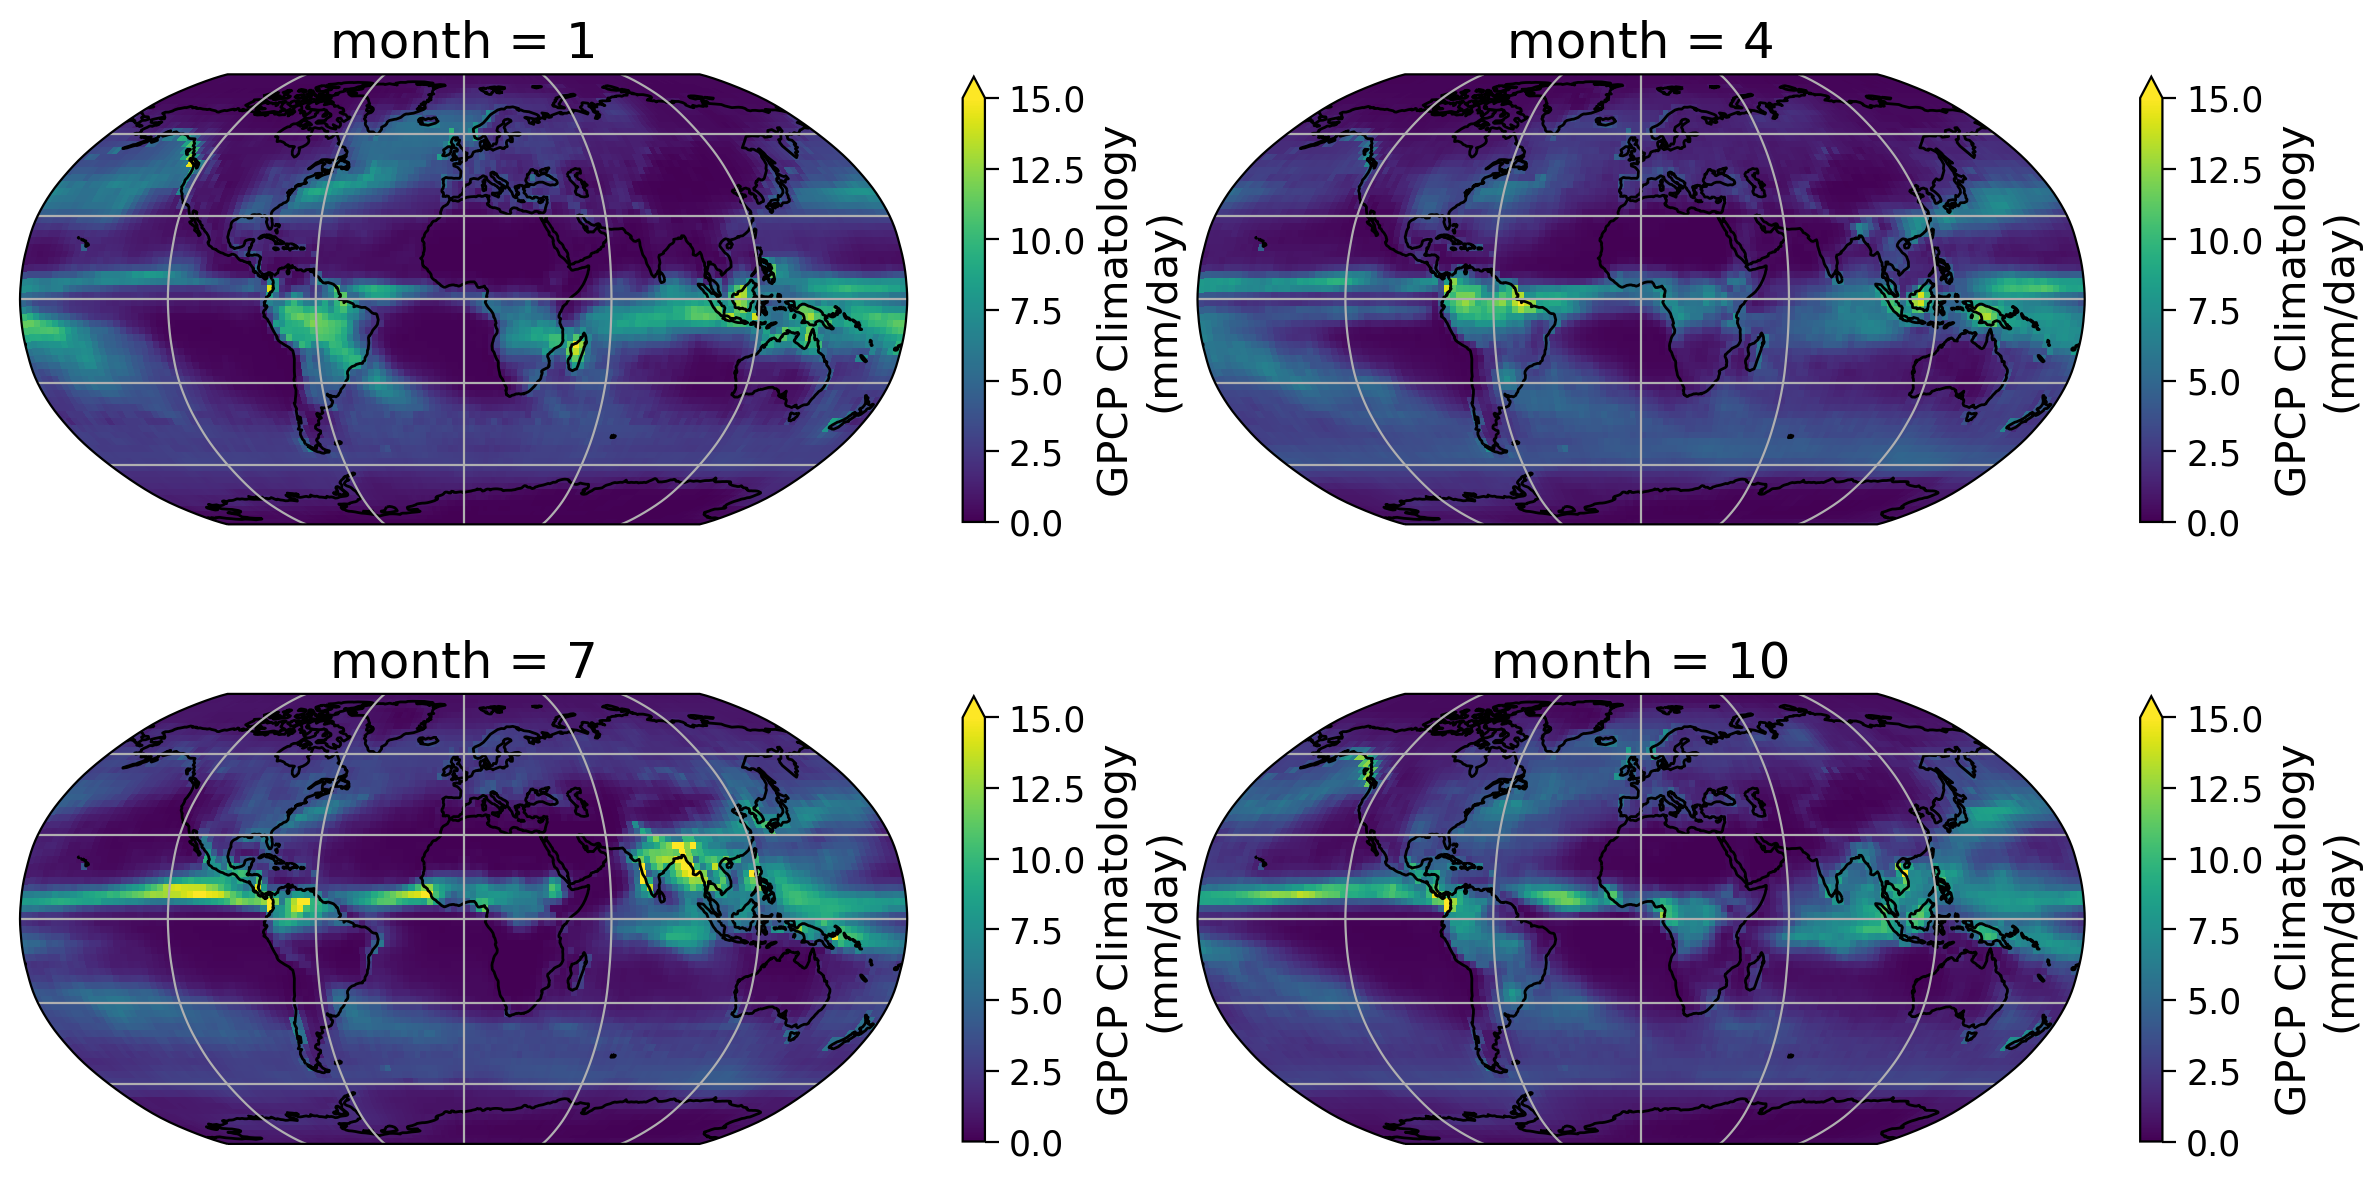

In [19]:
# Define the figure and each axis for the 2 rows and 2 columns
fig, axs = plt.subplots(nrows=2,ncols=2,
                        subplot_kw={'projection': ccrs.Robinson()},
                        figsize=(12,8))

# axs is a 2 dimensional array of `GeoAxes`.  We will flatten it into a 1-D array
axs=axs.flatten()

#Loop over selected months (Jan, Apr, Jul, Oct)
for i,month in enumerate([1,4,7,10]):

        # Draw the coastines and major gridline for each subplot
        axs[i].coastlines()
        axs[i].gridlines()
        
        # Draw the precipitation data
        precip_clim.sel(month=month).plot(ax=axs[i], transform=ccrs.PlateCarree(),
                        vmin = 0, vmax = 15, # use the same range of max and min value
                        cbar_kwargs=dict(shrink=0.5, label='GPCP Climatology\n(mm/day)'))
        
        

In the seasonal collection of the climatology map, we can see a clear pattern of precipitation across the globe. The tropics show higher amount of precipitation comparing to other regions. You can also see the seasonal patterns of the precipitation change across different region of the globe (e.g., moonsoon imapcted areas).

Now let's look at the climatology of the point that we examined its entire time series earlier (i.e., (0°N, 0°E)).

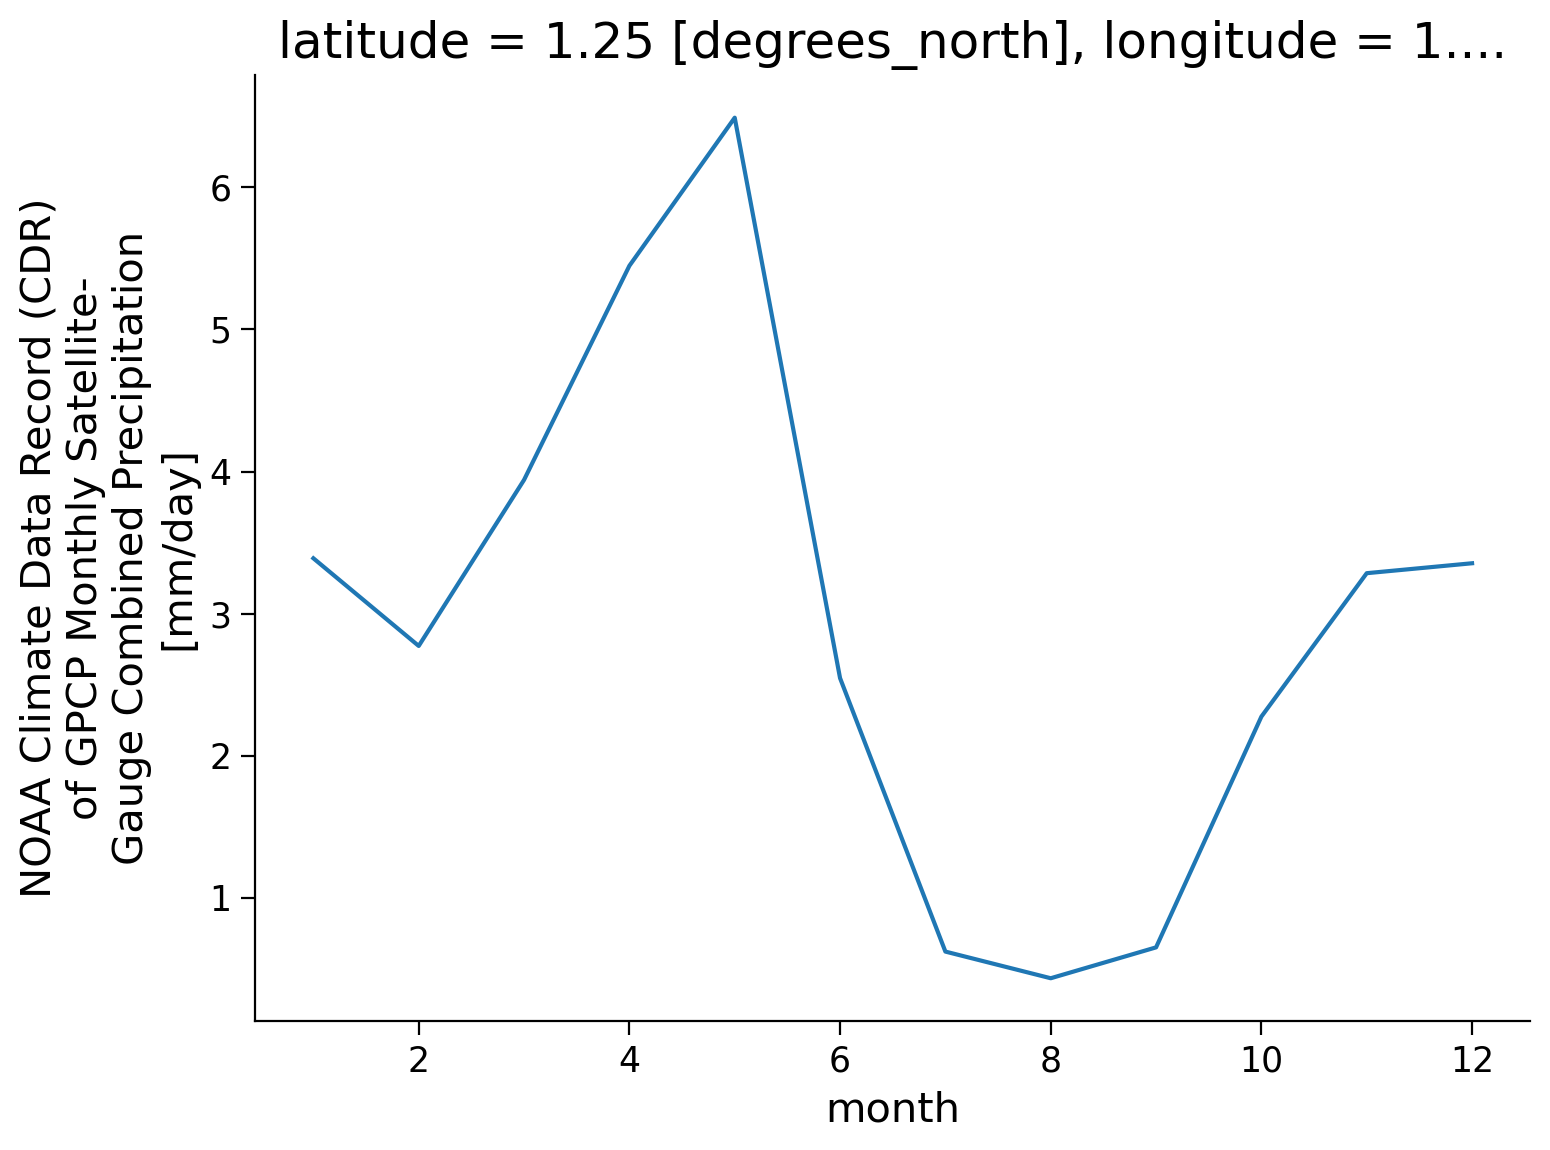

In [20]:
precip_clim.sel(latitude=0, longitude=0, method='nearest').plot()

The monthly climatology time series for the point of interest demonstrate a notable seasonal pattern of dry and rainy months for the region with more precipitation between December and May while August is the driest of the year.

Climatology tells us about how the weather typically is like. When we compare the weather of a specific day/month against the climatology, we will know how much it is different from the climatology, or the norm. This will be the content for our next tutorial - anomaly!

###**Coding Exercise 2.1: Calculate Climatology Change**

As the climate change, the climatology may also change. In fact, climate researchers recalculate climatology every 10 years. This allow climate scientists to monitor how the norm of our climate system changes.

In this exercise, can you calculate the climatology of a different time period (1991-2020) and comparing it to the climatology that we just generated in this tutorail?

In [21]:
################################################################################
# Exercise: Calculate precipitation climatology for 1991-2020 and comparing    # 
#           the climatology with the 1981-2010.                                #
################################################################################

# Step 1: Extract 30 year data for 1991-2020

# Step 2: Calculate climatology for 1991-2020

# Step 3: Comparing the climatology for four different seasons by generating the
#         difference maps for January, April, July, and October



'''

Please briefly describe the difference between two climatologies using GPCP
monthly data for two different

'''


'\n\nPlease briefly describe the difference between two climatologies using GPCP\nmonthly data for two different\n\n'

#**Summary**

In this tutorial, we learned about what is climatology.

* Climatology often refers to the average state of the system (e.g., mean temperature, precipitation, etc) over a long period of time (typically 30 years).
* Satellite climate data records can be used to calculate climatology at global scale.

We will use the climatology skill learned from this tutorial in the next tutorial on anomaly.